## MUSIC/VOICE SEPARATION USING THE 2D FOURIER TRANSFORM
* *Audio Source seperation* is the act of isolating sound sources ina and audio scene.

In [1]:
!wget https://github.com/ZahraBenslimane/SoundSourceSeparation_usingNMF/raw/main/data/piano_mix.wav

--2023-09-22 03:48:06--  https://github.com/ZahraBenslimane/SoundSourceSeparation_usingNMF/raw/main/data/piano_mix.wav
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZahraBenslimane/SoundSourceSeparation_usingNMF/main/data/piano_mix.wav [following]
--2023-09-22 03:48:07--  https://raw.githubusercontent.com/ZahraBenslimane/SoundSourceSeparation_usingNMF/main/data/piano_mix.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308100 (301K) [audio/wav]
Saving to: ‘piano_mix.wav’

piano_mix.wav       100%[===================>] 300.88K  --.-KB/s    in 0.1s    

2023-09-22 03:48:07 (2.33 MB/s) - ‘pi

In [49]:
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy.ndimage.filters as filters
import soundfile as sf

In [3]:
AUDIO_FILE = 'piano_mix.wav'
SAMPLE_RATE = 5512
FFT_SIZE = 1024
HOP_SIZE = FFT_SIZE // 8
WindowLengthAlongRateAxis = 70

In [4]:
ipd.Audio(AUDIO_FILE)

In [5]:
audio_sound, sr = librosa.load(AUDIO_FILE, sr=SAMPLE_RATE)

In [28]:
stftFull = librosa.stft(audio_sound, n_fft=FFT_SIZE, hop_length=HOP_SIZE)
stftMangnitude = 20*np.log(np.abs(stftFull))
stftTranspose = stftMangnitude.T**0.125

<ipython-input-28-16c3921e4627>:3: RuntimeWarning: invalid value encountered in power
  stftTranspose = stftMangnitude.T**0.125


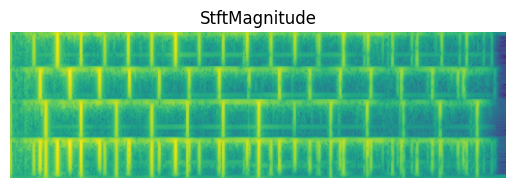

In [29]:
plt.axis("off")
plt.title("StftMagnitude")
plt.imshow(stftMangnitude.T)
fig = plt.gcf()
ax = plt.gca()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("original_spectrum.png", bbox_inches=extent, pad_inches=0, transparent=True)

In [8]:
def MakeMask(input):
    print("Making mask(Local maxima)...")
    data = 20*np.log(np.abs(input))
    dataarray = np.array(data, dtype=np.float64)
    StdDeviation = np.std(data)
    print(StdDeviation)
    threshold = StdDeviation   #10
    neighborhood_size = (1, WindowLengthAlongRateAxis)
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    mask = np.where((diff == 1), 1, 0)
    return mask

In [9]:
def MakeCrudeMask(input):
    print("Making crude mask(Global maxima)...")
    max1 = np.max(input)
    min1 = np.min(input)
    print('{},{}'.format(max1, min1))
    CrudeMask = np.where(np.logical_and(-1000 <= input, input <= max1), 1, 0)
    return CrudeMask

In [16]:
def FourierTransform(input):
  FT = np.fft.fft2(input)
  return FT

In [15]:
def InvFourierTransform(input):
  IFT = np.fft.ifft2(input)
  return IFT

In [42]:
def IstftForReconstruction(X, fft_size, hopsamp):
    print("Calculating Inverse STFT...")
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    window = np.hanning(fft_size)
    time_slices = X.shape[0]
    len_samples = int(time_slices*hopsamp + fft_size)
    x = np.zeros(len_samples)
    for n,i in enumerate(range(0, len(x)-fft_size, hopsamp)):
        x[i:i+fft_size] += window*np.real(np.fft.irfft(X[n]))
    return x

In [10]:
twoDFourierT = np.fft.fft2(stftFull)
SCBackgroundMask = MakeMask(twoDFourierT)
SCBackgroundMask1 = MakeCrudeMask(twoDFourierT)

Making mask(Local maxima)...
36.14217143766863
Making crude mask(Global maxima)...
(1529.7446113117057-418.89983243336405j),(-1443.1019114791306+94.22473030603464j)


<ipython-input-8-0f5a6aac6d89>:9: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = filters.maximum_filter(data, neighborhood_size)
<ipython-input-8-0f5a6aac6d89>:11: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_min = filters.minimum_filter(data, neighborhood_size)


In [11]:
SCForegroundMask = 1- SCBackgroundMask

In [12]:
input6 = twoDFourierT.copy()
input7 = twoDFourierT.copy()
input6 = np.multiply(SCBackgroundMask, input6)
input7 = np.multiply(SCForegroundMask, input7)
TwoDFourierTMag = 20*np.log(np.abs(input6))

<ipython-input-12-de05d65b4fd5>:5: RuntimeWarning: divide by zero encountered in log
  TwoDFourierTMag = 20*np.log(np.abs(input6))


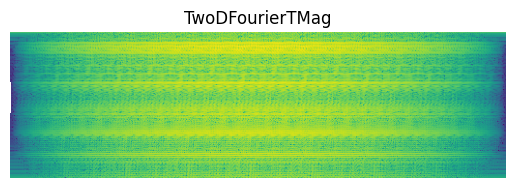

In [14]:
plt.axis("off")
plt.title("TwoDFourierTMag")
plt.imshow(TwoDFourierTMag.T)

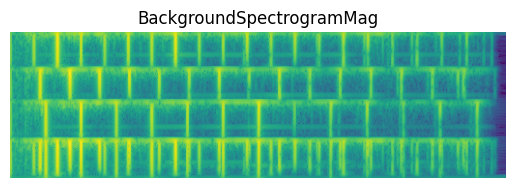

In [17]:
backgroundSpectrogram = abs(InvFourierTransform(input6))
foregroundSpectrogram = abs(InvFourierTransform(input7))

backgroundSpectrogramMag = 20*np.log(np.abs(backgroundSpectrogram))
foregroundSpectrogramMag = 20*np.log(np.abs(foregroundSpectrogram))

backgroundSpectrogramMagT = backgroundSpectrogramMag.T
foregroundSpectrogramMagT = foregroundSpectrogramMag.T

plt.axis("off")
plt.title("BackgroundSpectrogramMag")
plt.imshow(backgroundSpectrogramMagT)
fig = plt.gcf()
ax = plt.gca()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("BackgroundSpectrogramMag.png", bbox_inches=extent, pad_inches=0, transparent=True)

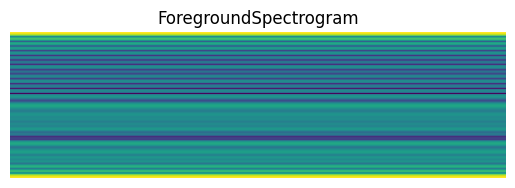

In [19]:
plt.axis("off")
plt.title("ForegroundSpectrogram")
plt.imshow(foregroundSpectrogramMagT)
fig = plt.gcf()
ax = plt.gca()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("foregroundSpectrogramMag.png", bbox_inches=extent, pad_inches=0, transparent=True)

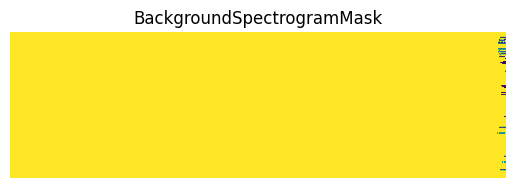

In [31]:
tfBackgroundMask = np.where((backgroundSpectrogram > foregroundSpectrogram),1 , 0)
tfForegroundMask = 1 - tfBackgroundMask


plt.axis("off")
plt.title("BackgroundSpectrogramMask")
plt.imshow(tfBackgroundMask.T)
fig = plt.gcf()
ax = plt.gca()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("BackgroundSpectrogramMask.png", bbox_inches=extent, pad_inches=0, transparent=True)

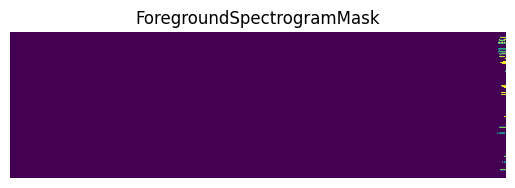

In [33]:
plt.axis("off")
plt.title("ForegroundSpectrogramMask")
plt.imshow(tfForegroundMask.T)
fig = plt.gcf()
ax = plt.gca()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("ForegroundMask.png", bbox_inches=extent, pad_inches=0, transparent=True)

<ipython-input-40-e61e29c70fe6>:2: RuntimeWarning: divide by zero encountered in log
  BGSpectrogramToBeRecon = 20*np.log(np.abs(BGSpectrogramToBeRecon.T))
<ipython-input-40-e61e29c70fe6>:5: RuntimeWarning: divide by zero encountered in log
  FGSpectrogramToBeRecon = 20*np.log(np.abs(FGSpectrogramToBeRecon.T))


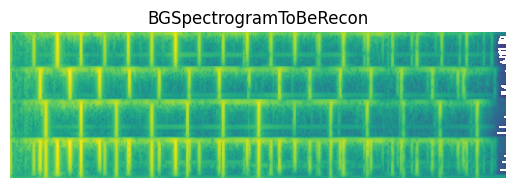

In [40]:
BGSpectrogramToBeRecon = np.multiply(tfBackgroundMask, np.abs(stftFull))
BGSpectrogramToBeRecon = 20*np.log(np.abs(BGSpectrogramToBeRecon.T))

FGSpectrogramToBeRecon = np.multiply(tfForegroundMask, np.abs(stftFull))
FGSpectrogramToBeRecon = 20*np.log(np.abs(FGSpectrogramToBeRecon.T))

plt.axis("off")
plt.title("BGSpectrogramToBeRecon")
plt.imshow(BGSpectrogramToBeRecon)
fig = plt.gcf()
ax = plt.gca()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("BGSpectrogramToBeRecon.png", bbox_inches=extent, pad_inches=0, transparent=True)

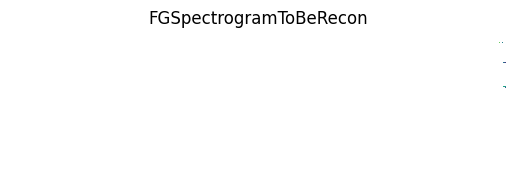

In [41]:
plt.axis("off")
plt.title("FGSpectrogramToBeRecon")
plt.imshow(FGSpectrogramToBeRecon)
fig = plt.gcf()
ax = plt.gca()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("FGSpectrogramToBeRecon.png", bbox_inches=extent, pad_inches=0, transparent=True)

In [44]:
bgAudioDataRecovered = IstftForReconstruction(BGSpectrogramToBeRecon, FFT_SIZE, HOP_SIZE)


Calculating Inverse STFT...


<ipython-input-42-c1ae8f852b3b>:10: RuntimeWarning: invalid value encountered in multiply
  x[i:i+fft_size] += window*np.real(np.fft.irfft(X[n]))


In [45]:
fgAudioDataRecovered = IstftForReconstruction(FGSpectrogramToBeRecon, FFT_SIZE, HOP_SIZE)


Calculating Inverse STFT...


<ipython-input-42-c1ae8f852b3b>:10: RuntimeWarning: invalid value encountered in multiply
  x[i:i+fft_size] += window*np.real(np.fft.irfft(X[n]))


In [53]:
max_sample = np.max(abs(bgAudioDataRecovered))
if max_sample > 1.0:
    bgAudioDataRecovered = bgAudioDataRecovered / max_sample

max_sample = np.max(abs(fgAudioDataRecovered))
if max_sample > 1.0:
    fgAudioDataRecovered = fgAudioDataRecovered / max_sample

In [55]:
sf.write("bg_audio.wav", bgAudioDataRecovered, 44100)

In [56]:
sf.write("fg_audio.wav", fgAudioDataRecovered, 44100)